# Mission


 
## Comment allez-vous procéder ? 
 
Cette mission suit un scénario de projet professionnel.

Vous pouvez suivre les étapes pour vous aider à réaliser vos livrables.
 

Avant de démarrer, nous vous conseillons de :

- lire toute la mission et ses documents liés ;
- prendre des notes sur ce que vous avez compris ;
- consulter les étapes pour vous guider ; 
- préparer une liste de questions pour votre première session de mentorat.

## Prêt à mener la mission ? 

**Future Vision Transport** est une entreprise qui conçoit des systèmes embarqués de vision par ordinateur pour les véhicules autonomes. 

Vous êtes l’un des ingénieurs IA au sein de l’équipe R&D de cette entreprise. Votre équipe est composée d’ingénieurs aux profils variés. 

Chacun des membres de l’équipe est spécialisé sur une des parties du système embarqué de vision par ordinateur. 

Voici les différentes parties du système :

- acquisition des images en temps réel
- traitement des images
- segmentation des images (c’est vous !)
- système de décision

Vous travaillez sur **la partie de segmentation des images** (3) qui est **alimentée par le bloc de traitement des images** (2) et **qui alimente le système de décision**(4).

Votre rôle est de **concevoir un premier modèle de segmentation d’images** qui devra s’intégrer facilement dans la chaîne complète du système embarqué.

Lors d’une première phase de cadrage, vous avez récolté les avis de Franck et Laura, qui travaillent sur les parties avant et après votre intervention :

* Franck, en charge du traitement des images (2) :

Le jeu de données que Franck utilise est disponible à ce lien, ou en téléchargement direct à ces liens : 1 ou 2, (images segmentées et annotées de caméras embarquées).

 On a uniquement besoin des **8 catégories principales**(et non pas des 32 sous-catégories)

* Laura, en charge du système de décision (4)

**Souhaite une API simple à utiliser.**
L’API prend en entrée une image et renvoie la segmentation de l’image de l’algo.

![Capture d’écran 2025-06-06 à 11.29.56.png](<attachment:Capture d’écran 2025-06-06 à 11.29.56.png>)

Pour récapituler, vous avez dressé un plan d’action, avec les points suivants :

- **entraîner un modèle de segmentation des images sur les 8 catégories principales.** *Keras* est le framework de travail commun à toute l’équipe. Attention aux contraintes de Franck !
- **concevoir une API de prédiction (Flask ou FastAPI)** qui sera utilisée par Laura **et la déployer sur le Cloud**(Azure, Heroku, PythonAnywhere ou toute autre solution). Cette API prend en entrée une image et renvoie le mask prédit (segments prédits de l’image).
- **concevoir une application web (Flask, Streamlit) de présentation des résultats** **et la déployer sur le Cloud** (Azure, Heroku, PythonAnywhere ou toute autre solution). Cette application sera **l’interface pour tester l’API et afficher les images et masks**.
 

# Livrables

1. **Les scripts développés sur un notebook permettant l’exécution du pipeline complet** :
    - Ce livrable vous servira à présenter le caractère “industrialisable” de votre travail en particulier le générateur de données.

2. **Une API (Flask ou FastAPI) déployée sur le Cloud** (Azure, Heroku, PythonAnywhere ou toute autre solution), pour exposer votre modèle entraîné et qui recevra en entrée une image et retournera le mask prédit (les segments identifiés par votre modèle) :
    - Ce livrable permettra à Laura d’utiliser facilement votre modèle.

3. **Une application (Flask, Streamlit) de présentation des résultats qui consomme l’API de prédiction, déployée sur le Cloud** (Azure, Heroku, PythonAnywhere ou toute autre solution). Cette application sera *l’interface pour tester l’API et intégrera les fonctionnalités suivantes* : 
    - affichage de la **liste des id** des images disponibles, 
    - lancement de la **prédiction du mask** pour l’id sélectionné par appel à l’API, 
    - et **affichage de l’image réelle, du mask réel et du mask prédit.** 
    - Ce livrable permettra d’illustrer votre travail auprès de vos collègues
4. **Une note technique de 10 pages** environ contenant :
    - une présentation des **différentes approches** 
    - et une synthèse de **l’état de l’art**, 
    - la présentation plus détaillée du **modèle** et de **l’architecture** retenue, 
    - une **synthèse des résultats** obtenus (incluant les gains obtenus avec les approches d’augmentation des données) 
    - et une **conclusion** avec des pistes d’amélioration envisageables.
    - Ce livrable vous servira à présenter votre démarche technique à vos collègues.
5. **Un support de présentation** (type Power Point) de votre démarche méthodologique **(30 slides maximum)** :
    - Ce livrable vous permettra de présenter vos résultats à Laura.


  
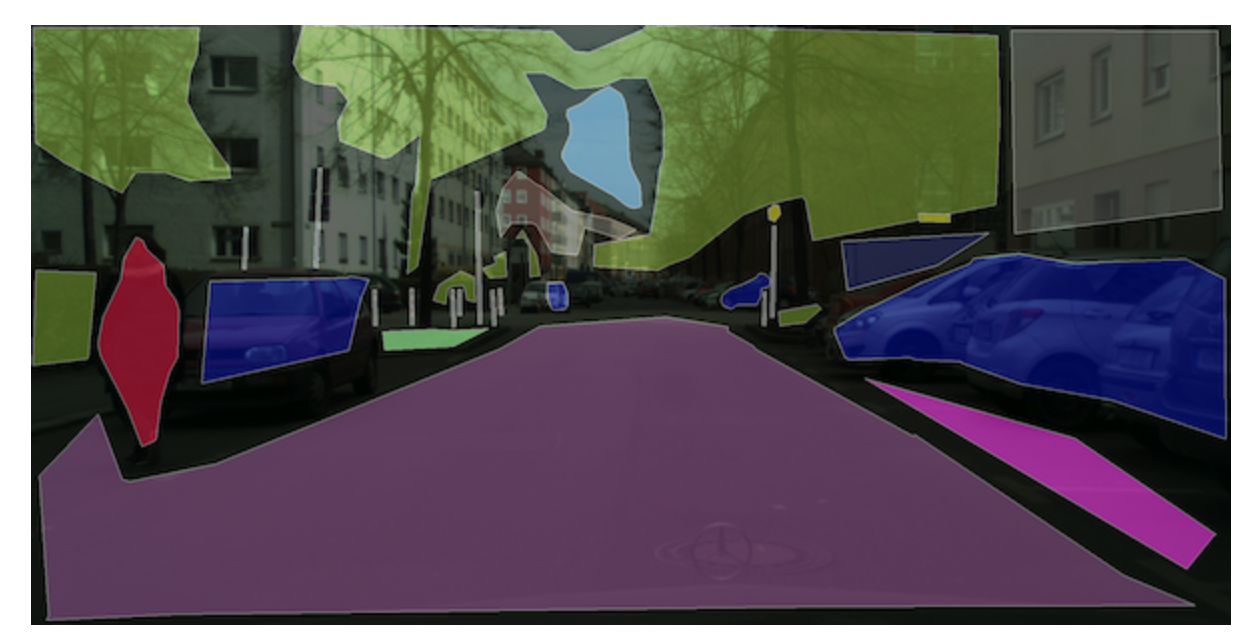

# Imports

In [1]:
# data & science
import pandas as pd
import math
from sklearn.model_selection import train_test_split
from collections import Counter
import numpy as np
print("numpy", np.__version__)

# system & tools
import time
import mlflow
print("mlflow", mlflow.__version__)
import os
import random
from collections import OrderedDict
import pathlib
from typing import Any, Optional, Dict
import sys
print(sys.executable)

# POO
from functools import cached_property
from typing import Optional, Union, Tuple, List, NamedTuple, Any

# graphiques
import matplotlib.pyplot as plt
from matplotlib.image import imread
import seaborn as sns
%matplotlib inline

# computer vision / CNN
from PIL import Image
import albumentations as A
import tensorflow as tf
tf.config.run_functions_eagerly(True)
#tf.data.experimental.enable_debug_mode()
from tensorflow.keras import layers, models
print("tensorflow", tf.__version__)
# # TensorFlow utilise un seul thread pour garantir la reproductibilité
# tf.config.threading.set_intra_op_parallelism_threads(1)
# tf.config.threading.set_inter_op_parallelism_threads(1)
import keras
print("keras", keras.__version__)

# Import local
from utils_p8 import labels
from classe_dataset import ImageSegmentationDataset

print("Number of CPU cores available: ", NUM_WORKERS := os.cpu_count())
# import keras
# print("keras", keras.__version__)
# from keras.applications import DenseNet121 


numpy 1.26.4


/opt/anaconda3/envs/env_p8_chantepie/lib/python3.10/site-packages/requests/__init__.py:86: RequestsDependencyWarning: Unable to find acceptable character detection dependency (chardet or charset_normalizer).
  warnings.warn(


mlflow 3.1.1
/opt/anaconda3/envs/env_p8_chantepie/bin/python


2025-08-11 18:01:48.406598: I tensorflow/core/platform/cpu_feature_guard.cc:210] This TensorFlow binary is optimized to use available CPU instructions in performance-critical operations.
To enable the following instructions: AVX2 FMA, in other operations, rebuild TensorFlow with the appropriate compiler flags.


tensorflow 2.16.2
keras 3.10.0
Number of CPU cores available:  8


# Présentation des métriques utilisées

Voici un résumé des principales métriques utilisées en segmentation d’images :

1. Indice de Jaccard (IoU – Intersection over Union)
    - Définition : Mesure le recouvrement entre le masque prédit et le masque réel.
    - Interprétation : Plus la valeur est proche de 1 (max : 1, min : 0), meilleur est le recouvrement.
    - Formule :

$$ IoU = \frac{|\text{Prédiction} \cap \text{Vérité terrain}|}{|\text{Prédiction} \cup \text{Vérité terrain}|} $$


2. mIoU (Mean Intersection over Union)
    - Définition : Moyenne de l’IoU calculée pour chaque classe.
    - Valeur cible : dépend du nombre de classes et du dataset, mais généralement plus la valeur est élevée, meilleure est la segmentation sur toutes les classes. (0.5 : bon pour segmentation multi-classes urbaine, 0.7 : excellent)
    - Utilité : Permet d’évaluer la performance globale sur toutes les classes, utile pour les datasets déséquilibrés.

3. Dice Coefficient (F1 Score pour la segmentation)
    - Définition : Mesure la similarité entre deux ensembles.
    - Interprétation : Comme l’IoU, mais donne plus de poids à l’intersection.
    - Valeur cible : proche de 1 (max : 1, min : 0) Plus la valeur est proche de 1, meilleur est le recouvrement entre masque prédit et masque réel.
    - Formule :
$$ Dice = \frac{2 \times |\text{Prédiction} \cap \text{Vérité terrain}|}{|\text{Prédiction}| + |\text{Vérité terrain}|} $$

4. Pixel Accuracy
    - Définition : Proportion de pixels correctement classés.
    - Valeur cible : proche de 1 (max : 1, min : 0)
    - Limite : Peut être trompeuse si certaines classes sont très majoritaires.
    - Formule simplifiée : la plus courante pour la segmentation multi-classes (le terme "pixels corrects" inclut tous les pixels bien classés, qu’ils soient positifs (appartenant à la classe) ou négatifs (n’appartenant pas à la classe))
$$ \text{Pixel Accuracy} = \frac{\text{Nombre de pixels corrects}}{\text{Nombre total de pixels}} $$  
   
**En résumé :**
- les IoU et Dice sont les plus utilisées pour évaluer la qualité du recouvrement des masques.
- la mIoU permet une évaluation globale multi-classes.
- la Pixel Accuracy donne une vue d’ensemble mais peut masquer les erreurs sur les classes minoritaires.

*sources :* 
*https://docs.pytorch.org/vision/stable/ops.html*

*https://www.tensorflow.org/api_docs/python/tf/keras/metrics*

*https://www.jeremyjordan.me/evaluating-image-segmentation-models/*

In [2]:

def dice_coef_metric(y_true, y_pred, num_classes=8, smooth=1e-5):
    """
    Calcule le Dice coefficient pour la segmentation multi-classes.
    - y_true : masque de vérité terrain (sparse, shape [batch, H, W])
    - y_pred : prédictions du modèle (probabilités softmax, shape [batch, H, W, num_classes])
    - num_classes : nombre de classes
    - smooth : facteur de lissage pour éviter la division par zéro
    Retourne la moyenne du Dice sur toutes les classes.
    """
    # convert les labels sparse en one-hot
    y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=num_classes)
    # convertit en one-hot la classe prédite (argmax sur les probabilités softmax) 
    y_pred_indices = tf.argmax(y_pred, axis=-1)
    y_pred_onehot = tf.one_hot(y_pred_indices, depth=num_classes)
    # flatten les masques pour le calcul
    y_true_flat = tf.reshape(y_true_onehot, [-1, num_classes])
    y_pred_flat = tf.reshape(y_pred_onehot, [-1, num_classes])
    # Calcule l'intersection et la somme  de la prédiction et de la vérité terrain pour chaque classe
    intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=0)
    somme = tf.reduce_sum(y_true_flat, axis=0) + tf.reduce_sum(y_pred_flat, axis=0)
    dice = (2. * intersection + smooth) / (somme + smooth)
    # Retourne la moyenne sur toutes les classes
    return tf.reduce_mean(dice)

def pixel_accuracy_metric(y_true, y_pred):
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int64)
    matches = tf.equal(y_true, y_pred_labels)
    return tf.reduce_mean(tf.cast(matches, tf.float32))


def mean_iou_metric(y_true, y_pred, num_classes=8, smooth=1e-5):
    """
    Calcule la mIoU (mean Intersection over Union) pour la segmentation multi-classes.
    - y_true : masque de vérité terrain (sparse, shape [batch, H, W])
    - y_pred : prédictions du modèle (probabilités softmax, shape [batch, H, W, num_classes])
    - num_classes : nombre de classes
    - smooth : facteur de lissage pour éviter la division par zéro
    Retourne la moyenne de l'IoU sur toutes les classes.
    """
    y_pred_labels = tf.argmax(y_pred, axis=-1)
    y_true = tf.cast(y_true, tf.int64)
    ious = []
    for i in range(num_classes):
        true = tf.equal(y_true, i)
        pred = tf.equal(y_pred_labels, i)
        intersection = tf.reduce_sum(tf.cast(true & pred, tf.float32))
        union = tf.reduce_sum(tf.cast(true | pred, tf.float32))
        iou = (intersection + smooth) / (union + smooth)
        ious.append(iou)
    return tf.reduce_mean(tf.stack(ious))


# def iou_coef_metric(y_true, y_pred, smooth=1e-5):
#     y_pred_labels = tf.argmax(y_pred, axis=-1)
#     y_true_f = tf.cast(tf.reshape(y_true, [-1]), tf.float32)
#     y_pred_f = tf.cast(tf.reshape(y_pred_labels, [-1]), tf.float32)
#     intersection = tf.reduce_sum(y_true_f * y_pred_f)
#     union = tf.reduce_sum(y_true_f) + tf.reduce_sum(y_pred_f) - intersection
#     return (intersection + smooth) / (union + smooth)

# def mean_iou(y_true, y_pred, num_classes=8):
#     y_pred_labels = tf.argmax(y_pred, axis=-1)
#     y_true = tf.cast(y_true, tf.int64)
#     ious = []
#     for i in range(num_classes):
#         true = tf.equal(y_true, i)
#         pred = tf.equal(y_pred_labels, i)
#         intersection = tf.reduce_sum(tf.cast(true & pred, tf.float32))
#         union = tf.reduce_sum(tf.cast(true | pred, tf.float32))
#         iou = tf.cond(union > 0, lambda: intersection / union, lambda: tf.constant(0.0))
#         ious.append(iou)
#     return tf.reduce_mean(tf.stack(ious))

# def mean_iou_metric(y_true, y_pred):
#     return mean_iou(y_true, y_pred, num_classes=8)

## Dice coefficient 
pour suivre l'évolution du dice coefficient à chaque époch de train et pour l'évaluation du modèle sur le test, je vais créer une classe qui héritera de tf.keras.metrics.Metric.


In [3]:


#@tf.keras.utils.register_keras_serializable(package="custom", name="DiceMetric") # Le décorateur permet de sauvegarder/charger la métrique dans un modèle Keras.
@keras.saving.register_keras_serializable()
class DiceMetric(tf.keras.metrics.Metric): # déclaration de la classe avec héritage de tf.keras.metrics.Metric
    """
    Dice coefficient pour segmentation sémantique avec labels sparse.
    Utilisable comme métrique ou fonction de perte personnalisée.
    """
    def __init__(
        self,
        num_classes: int = 8,
        smooth: float = 1e-5, # facteur de lissage pour éviter la division par zéro
        name: str = "Dice",
        **kwargs: Any,
    ) -> None:
        super().__init__(name=name, **kwargs)
        self.num_classes = num_classes
        self.smooth = smooth
        self.total_dice = self.add_weight(name="total_dice", initializer="zeros") # somme des scores Dice
        self.count = self.add_weight(name="count", initializer="zeros") # nombre total d'image traités dans tous les batchs

    # méthode appelée à chaque batch pour mettre à jour les scores
    def update_state(
        self,
        y_true: tf.Tensor,
        y_pred: tf.Tensor,
        sample_weight: Optional[tf.Tensor] = None,
    ) -> None:
        # Convertit les labels sparse en one-hot
        y_true_onehot = tf.one_hot(y_true, depth=self.num_classes)
        # Prend la classe prédite (argmax sur les probabilités softmax) et convertit en one-hot
        y_pred_indices = tf.argmax(y_pred, axis=-1)
        y_pred_onehot = tf.one_hot(y_pred_indices, depth=self.num_classes)
        # aplatit les maqsues pour le calcul (batch, H*W, num_classes)
        y_true_flat = tf.reshape(y_true_onehot, [tf.shape(y_true_onehot)[0], -1, self.num_classes])
        y_pred_flat = tf.reshape(y_pred_onehot, [tf.shape(y_pred_onehot)[0], -1, self.num_classes])
        # calcul intersection et union pour chaque batch
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)
        union = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(y_pred_flat, axis=1)
        # score Dice pour chaque classe et moyenne sur les classes pour chaque image
        dice = (2.0 * intersection + self.smooth) / (union + self.smooth)
        dice_per_image = tf.reduce_mean(dice, axis=-1)
        # enregistre la somme des scores Dice et le nombre d’images traitées 
        self.total_dice.assign_add(tf.reduce_sum(dice_per_image))
        # maj le nb d’images traitées sur l'epoch
        self.count.assign_add(tf.cast(tf.size(dice_per_image), tf.float32))

    # score Dice moyen sur tout le dataset
    def result(self) -> tf.Tensor:
        return self.total_dice / self.count

    # réinitialise les variables d’état (scores) au début d’une nouvelle epoch
    def reset_states(self) -> None:
        self.total_dice.assign(0.0)
        self.count.assign(0.0)

    # sérialisation de la métrique pour la sauvegarde et le reload du modèle
    def get_config(self) -> Dict[str, Any]:
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "smooth": self.smooth,
        })
        return config
    


## Suivi et visualisation des performances des modèles

Je vais créer une classe Preformance_model pour gérer l'analyse et la visualisation des métriques (iou, miou, dice coeff et pixel accuracy)

Focnitons voulues :
- Sauvegarder les historiques de métriques d'entraînement et de test par expérience avec mlflow et récupérable dans un dataframe en @cached_property
- Produire des visualisations dans le notebook pour:
    - Analyse de l'évolution de la perte lors de l'entraînement
    - Analyse de l'évolution des métriques lors de l'entraînement
    - Analyse des métriques sur l'évaluation du modèle sur le jeu de test

In [4]:
# import mlflow
# import pandas as pd
# import matplotlib.pyplot as plt
# from functools import cached_property

# class PerformanceModel:
#     """
#     Classe pour gérer l'analyse et la visualisation des métriques de segmentation (IoU, mIoU, Dice, Pixel Accuracy).
#     - Sauvegarde des historiques de métriques avec mlflow.
#     - Visualisation des courbes d'entraînement et d'évaluation.
#     """

#     def __init__(self, run_id: str):
#         self.run_id = run_id

#     @cached_property
#     def metrics_df(self) -> pd.DataFrame:
#         """
#         Récupère les métriques de l'expérience mlflow sous forme de DataFrame.
#         """
#         client = mlflow.tracking.MlflowClient()
#         metrics = client.get_run(self.run_id).data.metrics
#         return pd.DataFrame([metrics])

#     def plot_loss(self):
#         """
#         Affiche l'évolution de la perte lors de l'entraînement.
#         """
#         client = mlflow.tracking.MlflowClient()
#         history = client.get_run(self.run_id).data.metrics
#         if "train_loss" in history and "val_loss" in history:
#             plt.plot(history["train_loss"], label="train_loss")
#             plt.plot(history["val_loss"], label="val_loss")
#             plt.xlabel("Epochs")
#             plt.ylabel("Loss")
#             plt.title("Courbe de perte")
#             plt.legend()
#             plt.show()

#     def plot_metrics(self):
#         """
#         Affiche l'évolution des métriques principales lors de l'entraînement.
#         """
#         client = mlflow.tracking.MlflowClient()
#         history = client.get_run(self.run_id).data.metrics
#         for metric in ["iou", "miou", "dice", "pixel_accuracy"]:
#             if metric in history:
#                 plt.plot(history[metric], label=metric)
#         plt.xlabel("Epochs")
#         plt.ylabel("Score")
#         plt.title("Courbes des métriques")
#         plt.legend()
#         plt.show()

#     def plot_test_metrics(self):
#         """
#         Affiche les métriques sur le jeu de test.
#         """
#         df = self.metrics_df
#         test_metrics = ["test_iou", "test_miou", "test_dice", "test_pixel_accuracy"]
#         df_test = df.filter(items=test_metrics)
#         df_test.T.plot(kind="barh", legend=False)
#         plt.title("Métriques sur le jeu de test")
#         plt.xlabel("Score")
#         plt.show()

# Fonction de perte 

Voici les fonctions de perte les plus recommandées pour la segmentation d’images multi-classes avec classes déséquilibrées

1. Categorical Crossentropy / Sparse Categorical Crossentropy
    - compare la distribution des classes prédites (softmax) à la vérité terrain (one-hot ou sparse).
    - pénalise les erreurs de classification pixel par pixel.
    - peut être pondérée pour gérer le déséquilibre des classes.
    - standard pour la segmentation multi-classes.
    - Limite : Sensible au déséquilibre.

2. Dice Loss
    - mesure le recouvrement entre le masque prédit et le masque réel.
    - Optimise directement le Dice coefficient (similaire au F1-score).
    - moins sensible au déséquilibre des classes : favorise le bon recouvrement des classes minoritaires.
    - Souvent combinée avec une crossentropy pour plus de robustesse.

3. Focal Loss (crossentropy modifiée)
    - modifie le calcul de la crossentropy pour accorder plus d’importance aux exemples difficiles (mal classés).
    - réduit l’impact des exemples faciles (bien classés).
    - efficacité démontrée sur les datasets avec classes déséquilibrées.
    - Peut être utilisée seule ou combinée avec Dice Loss.

4. Combo Loss (Dice + Crossentropy ou Dice + Focal)
    - Combine deux fonctions de perte pour profiter de leurs avantages.
    - pour optimiser à la fois le recouvrement (Dice) et la classification (Crossentropy/Focal).
    - améliore la robustesse et la gestion du déséquilibre
    - Très utilisée en compétition et en recherche pour la segmentation médicale ou urbaine.


**Choix de la loss**
- pour notre projet actuel de segmentation d’images urbaines (caméra de voiture autonome), nous allons donc choisir la combo loss Dice + Focal : 
    - La Focal Loss gère très bien le déséquilibre des classes, fréquent en milieu urbain par la présence d'objets de tailles très variées (cf data.ipynb) 
    - La Dice Loss optimise le recouvrement des masques, ce qui est crucial pour la précision des contours et des objets.
- la combinaison des deux fonctions de loss devrait permettre d’obtenir de meilleurs résultats sur les classes minoritaires et une segmentation plus robuste.
- pour des raisons de coût et de temps, nous ne testerons pas les autres loss, mais cela pourrait être un axe d'amélioration pour de futurs développements

*sources :*

*https://www.tensorflow.org/api_docs/python/tf/keras/losses/CategoricalCrossentropy*

*https://www.kaggle.com/code/bigironsphere/loss-function-library-keras-pytorch/notebook*

*https://arxiv.org/abs/1805.02798*

*https://www.jeremyjordan.me/semantic-segmentation/#loss*

*https://arxiv.org/abs/1708.02002*

  

In [5]:
# déclara la classe pour notre combo loss qui hérite de tf.keras.losses.Loss.
#@tf.keras.utils.register_keras_serializable()
@keras.saving.register_keras_serializable()
class DiceFocalLoss(tf.keras.losses.Loss):
    """
    calcule la combo loss Dice + Focal, adaptée à la segmentation multi-classes avec déséquilibre.
    utilisable directement dans model.compile(loss=DiceFocalLoss(...))
    """
    def __init__(
        self,
        num_classes: int = 8,
        dice_smooth: float = 1e-5, # facteur de lissage pour éviter la division par zéro
        focal_gamma: float = 2.0,
        focal_alpha: float = 0.25,
        dice_weight: float = 0.5, # poids du composant dans le calcul de la combo loss
        focal_weight: float = 0.5, # poids du composant dans le calcul de la combo loss
        name: str = "DiceFocalLoss",
        **kwargs: Any,
    ):
        super().__init__(name=name, **kwargs) # call du contructeur parent
        self.num_classes = num_classes
        self.dice_smooth = dice_smooth
        self.focal_gamma = focal_gamma
        self.focal_alpha = focal_alpha
        self.dice_weight = dice_weight
        self.focal_weight = focal_weight

    def call(self, y_true, y_pred):
        # Dice Loss
        # Convertit les labels sparse en one-hot
        y_true_onehot = tf.one_hot(tf.cast(y_true, tf.int32), depth=self.num_classes)
        # Applique softmax sur les prédictions
        y_pred_softmax = tf.nn.softmax(y_pred, axis=-1)
        # Aplati les masques pour le calcul
        y_true_flat = tf.reshape(y_true_onehot, [tf.shape(y_true_onehot)[0], -1, self.num_classes])
        y_pred_flat = tf.reshape(y_pred_softmax, [tf.shape(y_pred_softmax)[0], -1, self.num_classes])
        # Calcule intersection et union
        intersection = tf.reduce_sum(y_true_flat * y_pred_flat, axis=1)
        union = tf.reduce_sum(y_true_flat, axis=1) + tf.reduce_sum(y_pred_flat, axis=1)
        # Calcule le Dice coefficient et la perte associée.
        dice = (2.0 * intersection + self.dice_smooth) / (union + self.dice_smooth)
        dice_loss = 1.0 - tf.reduce_mean(dice)

        # Focal Loss
        # Évite les log(0) avec un clipping
        epsilon = tf.keras.backend.epsilon()
        y_pred_clipped = tf.clip_by_value(y_pred_softmax, epsilon, 1.0 - epsilon)
        # Calcule la cross-entropy pixel par pixel
        cross_entropy = -y_true_onehot * tf.math.log(y_pred_clipped)
        # Applique le modulateur focal (plus de poids aux exemples difficiles)
        focal = self.focal_alpha * tf.pow(1 - y_pred_clipped, self.focal_gamma) * cross_entropy
        # moyenne la perte sur le batch
        focal_loss = tf.reduce_mean(tf.reduce_sum(focal, axis=-1))

        # Combo
        return self.dice_weight * dice_loss + self.focal_weight * focal_loss

    # sauvegarde de l'état et des paramètres de la loss pour pour le reload du modèle (=sérialisation de la loss)
    def get_config(self):
        config = super().get_config()
        config.update({
            "num_classes": self.num_classes,
            "dice_smooth": self.dice_smooth,
            "focal_gamma": self.focal_gamma,
            "focal_alpha": self.focal_alpha,
            "dice_weight": self.dice_weight,
            "focal_weight": self.focal_weight,
        })
        return config

# Modélisations

**1. UNet_mini**
* Principe

    - UNet est un réseau de neurones convolutionnel conçu pour la segmentation d’images (initialement en biomédical, aujourd’hui utilisé partout).
    - Il se compose de deux parties :
        - Encodeur : extrait les features (convolutions + pooling)
        - Décodeur : reconstruit la segmentation (upsampling + convolutions)
        - Skip connections : relient les couches symétriques encodeur/décodeur pour conserver l’information spatiale fine

    - UNet_mini est une version simplifiée :
        - Moins de couches et de filtres (pour réduire le coût de calcul)
        - Adapté aux petits datasets ou aux ressources limitées
        - Structure typique (UNet_mini)
        - Entrée : image RGB (ex : 256x512x3)
        - Encodeur : 2 blocs Conv2D + MaxPooling
        - Bottleneck : 1 bloc Conv2D
        - Décodeur : 2 blocs UpSampling2D + Conv2D
        - Sortie : Conv2D (softmax) pour la segmentation multi-classes

* Avantages

    - Très rapide à entraîner
    - Peu de paramètres
    - Facile à adapter à différents formats d’images

*Sources : https://arxiv.org/abs/1505.04597*

* Schéma

Entrée (Image RGB)
      |
[Conv2D + ReLU]  ----
      |              |
[MaxPooling]         |  <--- Skip connection
      |              |
[Conv2D + ReLU]  ----
      |
[MaxPooling]
      |
[Bottleneck Conv2D]
      |
[UpSampling2D]
      |
[Conv2D + ReLU]  <--- Skip connection
      |
[UpSampling2D]
      |
[Conv2D + ReLU]  <--- Skip connection
      |
[Conv2D (Softmax)]
      |
Sortie (Mask segmentation)


**2. VGG16_UNet**
* Principe

    - VGG16_UNet est une variante de UNet qui utilise VGG16 (réseau pré-entraîné sur ImageNet) comme encodeur.
    - On retire la partie “classification” (les couches denses) et on garde les couches convolutionnelles comme encodeur
    - Le décodeur UNet est ajouté pour la segmentation

* Structure typique
    - Encodeur : VGG16 (convolutions + pooling, poids pré-entraînés)
    - Skip connections : entre les blocs VGG16 et le décodeur
    - Décodeur : UpSampling2D + Conv2D, concaténation avec les sorties intermédiaires de VGG16
    - Sortie : Conv2D (softmax) pour la segmentation multi-classes

* Avantages
    - Bénéficie du transfert learning : les features extraites par VGG16 sont très robustes
    - Meilleure généralisation sur petits datasets
    - Plus précis sur les objets complexes

*Sources : https://medium.com/@saifgazali/retina-blood-vessel-segmentation-using-vgg16-unet-7262f97e1695*


* Schéma


Entrée (Image RGB)
      |
[ VGG16 Encoder ]
 |   |   |   |   |   (blocs convolutionnels pré-entraînés)
 |   |   |   |   |
 |   |   |   |   +-------------------+
 |   |   |   +-------------------+   |
 |   |   +-------------------+   |   |
 |   +-------------------+   |   |   |
 +-------------------+   |   |   |   |
      |                |   |   |   |
      |                |   |   |   |
      |                |   |   |   |
      |                |   |   |   |
      |                |   |   |   |
      |                |   |   |   |
      |                |   |   |   |
      |                |   |   |   |
      v                v   v   v   v
[ Decoder UNet ]
      |
[UpSampling2D + Concatenate (skip avec VGG16)]
      |
[Conv2D + ReLU]
      |
[UpSampling2D + Concatenate (skip avec VGG16)]
      |
[Conv2D + ReLU]
      |
[...]
      |
[Conv2D (Softmax)]
      |
Sortie (Mask segmentation)



## Paramètres d'entraînement

In [6]:
BATCH_SIZE = 8
SEED = 42
PATIENCE = 5
#OPTIMIZER = tf.keras.optimizers.Adam(learning_rate=0.001)

## Classes et fonctions d'entraînement et d'évaluation

In [7]:
# Modèle UNet_mini
def build_unet_mini(input_shape=(256, 512, 3), num_classes=8, loss=None):
    """
    Retourne un modèle UNet_mini compilé.
    """
    inputs = layers.Input(shape=input_shape)
    # Encoder simple
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(inputs)
    x = layers.MaxPooling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.MaxPooling2D()(x)
    # Bottleneck
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    # Decoder simple
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D()(x)
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)
    model = models.Model(inputs, outputs)
    
    per_class_metrics = [
    tf.keras.metrics.IoU(
        num_classes=8,
        target_class_ids=[i],
        name=f"IoU_class_{i}",
        sparse_y_true=True,
        sparse_y_pred=False,
        axis=-1,
    )
    for i in range(8)]

    
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
        loss=loss,
        metrics=[
            # tf.keras.metrics.MeanIoU(num_classes=num_classes, name="MeanIoU"),
            # tf.keras.metrics.SparseCategoricalAccuracy(name="Pixel_Accuracy"),
            #"accuracy"
            # pixel_accuracy_metric,
            # dice_coef_metric,
            # mean_iou_metric,
            DiceMetric(num_classes=num_classes, name="dice"),
            #tf.keras.metrics.MeanIoU(num_classes=num_classes, name="miou"),
            tf.keras.metrics.SparseCategoricalAccuracy(name="pixel_accuracy"),
            *per_class_metrics, 
        ],
    )
    print('loss', loss)
    model.summary()
    return model

# Modèle UNet avec un backbone VGG16 pré-entraîné
def build_vgg16_unet(input_shape=(256, 512, 3), num_classes=8, loss=None, freeze_encoder=True):
    """
    UNet avec backbone VGG16 pré-entraîné sur ImageNet.
    """
    # Encoder VGG16
    vgg16 = tf.keras.applications.VGG16(
        weights="imagenet", include_top=False, input_shape=input_shape
    )
    inputs = vgg16.input
    # Récupère les sorties intermédiaires pour les skip connections
    block1_out = vgg16.get_layer("block1_pool").output
    block2_out = vgg16.get_layer("block2_pool").output
    block3_out = vgg16.get_layer("block3_pool").output
    block4_out = vgg16.get_layer("block4_pool").output
    encoder_output = vgg16.get_layer("block5_pool").output

    # Decoder UNet
    # À chaque étape du décodeur, on concatène la sortie upsamplée avec la sortie correspondante du VGG16 (skip connection).
    x = layers.Conv2D(512, 3, activation="relu", padding="same")(encoder_output)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, block4_out])
    x = layers.Conv2D(256, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, block3_out])
    x = layers.Conv2D(128, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, block2_out])
    x = layers.Conv2D(64, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D()(x)
    x = layers.Concatenate()([x, block1_out])
    x = layers.Conv2D(32, 3, activation="relu", padding="same")(x)
    x = layers.UpSampling2D()(x) # dernier upsamplign pour revenir à la bonne taille d'image
    outputs = layers.Conv2D(num_classes, 1, activation="softmax")(x)

    model = models.Model(inputs, outputs)

    # gel de l'encodeur VGG16 : garder les poids pré-entraînés sans les modifier, accélérer le train, éviter l'overfitting
    if freeze_encoder:
        for layer in vgg16.layers:
            layer.trainable = False
    
    per_class_metrics = [
    tf.keras.metrics.IoU(
        num_classes=8,
        target_class_ids=[i],
        name=f"IoU_class_{i}",
        sparse_y_true=True,
        sparse_y_pred=False,
        axis=-1,
    )
    for i in range(8)]
        
    model.compile(
        optimizer=tf.keras.optimizers.AdamW(learning_rate=1e-4),
        loss=loss,
        metrics=[
            DiceMetric(num_classes=num_classes, name="dice"),
            #tf.keras.metrics.MeanIoU(num_classes=num_classes, name="miou"),
            tf.keras.metrics.SparseCategoricalAccuracy(name="pixel_accuracy"),
            *per_class_metrics, 
        ],
    )
    model.summary()
    return model


# def build_unet_mini_transfer(input_shape=(256, 512, 3), num_classes=8, loss=None, weights_path=None, freeze_encoder=True):
#     """
#     Charge un modèle UNet_mini pré-entraîné et prépare le transfert learning.
#     - weights_path : chemin vers les poids ou le modèle SavedModel.
#     - freeze_encoder : si True, gèle les couches de l'encodeur.
#     """
#     # Construction du modèle identique à build_unet_mini
#     inputs = layers.Input(shape=input_shape)
#     # Encoder
#     x = layers.Conv2D(32, 3, activation="relu", padding="same", name="enc_conv1")(inputs)
#     x = layers.MaxPooling2D(name="enc_pool1")(x)
#     x = layers.Conv2D(64, 3, activation="relu", padding="same", name="enc_conv2")(x)
#     x = layers.MaxPooling2D(name="enc_pool2")(x)
#     # Bottleneck
#     x = layers.Conv2D(128, 3, activation="relu", padding="same", name="bottleneck")(x)
#     # Decoder
#     x = layers.UpSampling2D(name="dec_up1")(x)
#     x = layers.Conv2D(64, 3, activation="relu", padding="same", name="dec_conv1")(x)
#     x = layers.UpSampling2D(name="dec_up2")(x)
#     x = layers.Conv2D(32, 3, activation="relu", padding="same", name="dec_conv2")(x)
#     outputs = layers.Conv2D(num_classes, 1, activation="softmax", name="output")(x)
#     model = models.Model(inputs, outputs)

#     # Charge les poids si fournis
#     if weights_path is not None:
#         model.load_weights(weights_path)
#         print(f"Weights loaded from {weights_path}")

#     # Gèle l'encodeur si demandé
#     if freeze_encoder:
#         for layer in model.layers:
#             if "enc_" in layer.name or "bottleneck" in layer.name:
#                 layer.trainable = False

#     model.compile(
#         optimizer="adam",
#         loss=loss,
#         metrics=[
#             pixel_accuracy_metric,
#             dice_coef_metric,
#             iou_coef_metric,
#             mean_iou_metric,
#         ],
#     )
#     model.summary()
#     return model

In [8]:
# orchestrer l'entrainement et l'évaluation des modèles de segmentation d'images
class SegmentationExperiment:
    """
    Orchestration de l'entraînement et de l'évaluation pour UNet_mini et VGG16_UNet
    avec ImageSegmentationDataset, DiceFocalLoss et suivi avec mlflow.
    """

    def __init__(self, model_fn, model_name, num_classes=8, input_shape=(256, 512, 3)):
        self.model_fn = model_fn  # fonction qui retourne le modèle compilé
        self.model_name = model_name
        self.num_classes = num_classes
        self.input_shape = input_shape

    def train_and_log(self, train_dataset, val_dataset, test_dataset, epochs=10, batch_size=BATCH_SIZE, mlflow_experiment="segmentation"):
        mlflow.set_experiment(mlflow_experiment)
        with mlflow.start_run(run_name=self.model_name) as run:
            # Instancie le modèle compilé
            model = self.model_fn(
                input_shape=self.input_shape,
                num_classes=self.num_classes,
                loss=DiceFocalLoss(num_classes=self.num_classes),
            )
            start_time = time.time()  

            # Callback pour logger les métriques dans mlflow
            class MLflowLogger(tf.keras.callbacks.Callback):
                def __init__(self, train_data, val_data, num_classes):
                    super().__init__()
                    self.train_data = train_data
                    self.val_data = val_data
                    self.num_classes = num_classes
                    # self.dice_metric = DiceMetric(num_classes=num_classes, name="dice")
                    # self.miou_metric = tf.keras.metrics.MeanIoU(num_classes=num_classes, name="miou")
                    # self.pixel_acc_metric = tf.keras.metrics.SparseCategoricalAccuracy(name="pixel_accuracy")

                def on_epoch_end(self, epoch, logs=None):
                        # Log standard Keras metrics
                    for k, v in logs.items():
                        mlflow.log_metric(k, v, step=epoch)
                        
                    # --- TRAIN ---
                    if self.train_data is not None:
                        y_true_train, y_pred_train = [], []
                        for batch in self.train_data:
                            if batch is None or len(batch) < 2:
                                continue
                            images, masks = batch[:2]
                            if images is None or masks is None or images.shape[0] == 0 or masks.shape[0] == 0:
                                continue
                            preds = self.model.predict(images)
                            y_true_train.append(masks)
                            y_pred_train.append(preds)
                        y_true_all = np.concatenate(y_true_train, axis=0)
                        y_pred_all = np.concatenate(y_pred_train, axis=0)
                        dice = dice_coef_metric(y_true_all, y_pred_all).numpy()
                        pixel_acc = pixel_accuracy_metric(y_true_all, y_pred_all).numpy()
                        miou = mean_iou_metric(y_true_all, y_pred_all).numpy()
                        mlflow.log_metric("train_dice_per_epoch", dice, step=epoch)
                        mlflow.log_metric("train_pixel_accuracy_per_epoch", pixel_acc, step=epoch)
                        mlflow.log_metric("train_miou_per_epoch", miou, step=epoch)
                        
                        # IoU par classe (train)
                        y_pred_labels = np.argmax(y_pred_all, axis=-1)
                        for class_idx in range(self.num_classes):
                            true_mask = (y_true_all == class_idx)
                            pred_mask = (y_pred_labels == class_idx)
                            intersection = np.logical_and(true_mask, pred_mask).sum()
                            union = np.logical_or(true_mask, pred_mask).sum()
                            iou = intersection / union if union > 0 else 0.0
                            mlflow.log_metric(f"train_iou_class_{class_idx}_per_epoch", iou, step=epoch)

                    # --- VALIDATION ---
                    y_true_val, y_pred_val = [], []
                    for batch in self.val_data:
                        if batch is None or len(batch) < 2:
                            continue
                        images, masks = batch[:2]
                        if images is None or masks is None or images.shape[0] == 0 or masks.shape[0] == 0:
                            continue
                        preds = self.model.predict(images)
                        y_true_val.append(masks)
                        y_pred_val.append(preds)
                    if len(y_true_val) > 0 and len(y_pred_val) > 0:
                        y_true_all = np.concatenate(y_true_val, axis=0)
                        y_pred_all = np.concatenate(y_pred_val, axis=0)
                        dice = dice_coef_metric(y_true_all, y_pred_all).numpy()
                        pixel_acc = pixel_accuracy_metric(y_true_all, y_pred_all).numpy()
                        miou = mean_iou_metric(y_true_all, y_pred_all).numpy()
                        mlflow.log_metric("val_dice_per_epoch", dice, step=epoch)
                        mlflow.log_metric("val_pixel_accuracy_per_epoch", pixel_acc, step=epoch)
                        mlflow.log_metric("val_miou_per_epoch", miou, step=epoch)
                        # IoU par classe (val)
                        y_pred_labels = np.argmax(y_pred_all, axis=-1)
                        for class_idx in range(self.num_classes):
                            true_mask = (y_true_all == class_idx)
                            pred_mask = (y_pred_labels == class_idx)
                            intersection = np.logical_and(true_mask, pred_mask).sum()
                            union = np.logical_or(true_mask, pred_mask).sum()
                            iou = intersection / union if union > 0 else 0.0
                            mlflow.log_metric(f"val_iou_class_{class_idx}_per_epoch", iou, step=epoch)

            # Fin du callback MLflowLogger                
            
            # Entraînement
            early_stopping = tf.keras.callbacks.EarlyStopping(
            monitor='val_loss',      
            patience=PATIENCE,       # nb d'epoch sans amélioration avant arrêt
            restore_best_weights=True) # pour restaurer les poids calculés à la meilleure epoch

            reduce_lr = tf.keras.callbacks.ReduceLROnPlateau(
            monitor='val_loss',      
            factor=0.5,              # facteur de réduction du learning rate
            patience=PATIENCE,       # nb d'epoch sans amélioration avant réduction
            min_lr=1e-6)              # learning rate minimum
            
            history = model.fit(
                train_dataset,
                validation_data=val_dataset,
                epochs=epochs,
                batch_size=batch_size,
                callbacks=[MLflowLogger(train_dataset, val_dataset, self.num_classes), early_stopping, reduce_lr],
                verbose=3,
            )

            print("model.metrics_names",model.metrics_names)
            
            print("Début du logging des métriques finales")
        

            # # Évaluation finale sur les 3 datasets 
           
            
            # dict_evaluation_finale = OrderedDict()
            # datasets = ["train", "val", "test"]
            # metrics = ["dice", "miou", "pixel_accuracy", "confusion_matrix"]

            # for dataset in datasets:
            #     y_true, y_pred = [], []
            #     if dataset == "train":
            #         data = train_dataset
            #     elif dataset == "val":
            #         data = val_dataset
            #     else:
            #         data = test_dataset
                
            #     for batch in data:
            #         images, masks = batch[:2]
            #         preds = model.predict(images)
            #         y_true.append(masks)
            #         y_pred.append(preds)
                
            #     y_true_all = np.concatenate(y_true, axis=0)
            #     y_pred_all = np.concatenate(y_pred, axis=0)
                
            #     dict_evaluation_finale[dataset] = OrderedDict()
            #     for metric in metrics:
            #         if metric == "dice":
            #             score = dice_coef_metric(y_true_all, y_pred_all).numpy()
            #         elif metric == "miou":
            #             score = mean_iou_metric(y_true_all, y_pred_all).numpy()
            #         elif metric == "pixel_accuracy":
            #             score = pixel_accuracy_metric(y_true_all, y_pred_all).numpy()
            #         elif metric == "confusion_matrix":
            #             y_true_labels = np.argmax(y_true_all, axis=-1)
            #             y_pred_labels = np.argmax(y_pred_all, axis=-1)
            #             score = tf.math.confusion_matrix(
            #                 y_true_labels.flatten(), 
            #                 y_pred_labels.flatten(), 
            #                 num_classes=self.num_classes
            #             ).numpy()
            #             filename = f"{dataset}_confusion_matrix.txt"
            #             with open(filename, "w") as f:
            #                 f.write(str(score))
            #             mlflow.log_artifact(filename)
            #             print(f"{dataset}_confusion_matrix:", score)
            #             dict_evaluation_finale[dataset][metric] = score
            #             continue
            #         else:
            #             raise ValueError(f"Metric {metric} not recognized")
                    
            #         mlflow.log_metric(f"{dataset}_{metric}_final", score)
            #         dict_evaluation_finale[dataset][metric] = score
            #         print(f"{dataset}_{metric}_final:", score)

            # log temps de calcul
            mlflow.log_metric(f"time_training pour {epochs} epochs", time.time() - start_time)

            # Log des paramètres
            mlflow.log_param("model_name", self.model_name)
            mlflow.log_param("data-augmentation", train_dataset.augmentations) 
            mlflow.log_param("epochs", epochs)
            mlflow.log_param("batch_size", batch_size)
            mlflow.log_param("num_classes", self.num_classes)
            mlflow.log_param("input_shape", self.input_shape)

            # Sauvegarde du modèle
            model.save(f"model{self.model_name}.keras") # Format Keras
            model.save(f"model{self.model_name}.h5") # Format HDF5
            model.export(f"model{self.model_name}_tf") # Format TensorFlow SavedModel (pour déploiement)
            mlflow.log_artifact(f"model{self.model_name}.keras") # Format Keras 
            mlflow.log_artifact(f"model{self.model_name}.h5") # Format HDF5
            mlflow.log_artifact(f"model{self.model_name}_tf") # Format TensorFlow SavedModel (pour déploiement)
      
            # Récupère le premier batch d'images du train_dataset
            images, *_ = train_dataset[0]  # images shape: (batch_size, 256, 512, 3)
            if isinstance(images, tf.Tensor):
                images = images.numpy()
            input_example = images[:1]  # batch de taille 1, shape: (1, 256, 512, 3)
            
            from mlflow.models.signature import infer_signature
            signature = infer_signature(input_example, model.predict(input_example))
            mlflow.keras.log_model(model, name="model", registered_model_name=self.model_name, signature=signature)
            
            # mlflow.keras.log_model(model, name="model", registered_model_name=self.model_name, input_example=input_example)
            # mlflow.keras.log_model( model, artifact_path="model",registered_model_name=self.model_name, input_example=input_example) #pas pour mlflow v3

            # doc mlflow pour charger le modèle enregistré: 
            # Example 0: Load via Tracking Server​
            # A model URI is a unique identifier for a serialized model. 
            # Given the model artifact is stored with experiments in the tracking server, you can use the below model URIs to bypass the model registry and load the artifact into memory.
            # Absolute local path: mlflow.sklearn.load_model("/Users/me/path/to/local/model")
            # Relative local path: mlflow.sklearn.load_model("relative/path/to/local/model")
            # Run id: mlflow.sklearn.load_model(f"runs:/{mlflow_run_id}/{run_relative_path_to_model}")
            # However, unless you're in the same environment that you logged the model, you typically won't have the above information. 
            # Instead, you should load the model by leveraging the model's name and version.

            # Example 1: Load via Name and Version
            # #After registering the model, you can load it back with the model name and version
            # model_uri = mlflow.keras.load_model("models:/<YOUR_MODEL_NAME>/<YOUR_MODEL_VERSION>")
    

            # Retourne le run_id pour analyse avec ModelMetricMLflow
            return run.info.run_id
    
    def load_model(self, model_name=None, model_version=None, run_id=None, local_path=None):
        """
        Charge le modèle sauvegardé dans MLflow ou en local (.h5, .keras, SavedModel).
        - model_name : nom du modèle enregistré (optionnel, par défaut self.model_name)
        - model_version : version du modèle (optionnel, si registry de mlflow utilisé)
        - run_id : id du run (optionnel)
        - local_path : chemin local vers le modèle (.h5, .keras ou dossier SavedModel)
        Retourne le modèle Keras prêt à l'emploi.
        """
        import mlflow
        import tensorflow as tf
        
        # charger le modèle au format Keras (.keras) ou HDF5 (.h5) ou TensorFlow SavedModel (dossier) en local
        if local_path is not None:
            model = tf.keras.models.load_model(local_path)
        # charger le modèle depuis MLflow
        elif model_version is not None:
            model_uri = f"models:/{model_name or self.model_name}/{model_version}"
            model = mlflow.keras.load_model(model_uri)
        elif run_id is not None:
            model_uri = f"runs:/{run_id}/model"
            model = mlflow.keras.load_model(model_uri)
        else:
            model = mlflow.keras.load_model("model")
        return model
    
    # évaluation finale des métriques sur les 3 datasets (train, val, test)
    # pour le modèle chargé
    # retourne un dictionnaire avec les scores finaux pour chaque dataset et chaque métrique
    def evaluate_final_metrics(self, model, train_dataset, val_dataset, test_dataset):
        dict_evaluation_finale = OrderedDict()
        datasets = {"train": train_dataset, "val": val_dataset, "test": test_dataset}
        metrics = ["dice", "miou", "pixel_accuracy", 
                   #"confusion_matrix"
                   ]

        for dataset_name, data in datasets.items():
            y_true, y_pred = [], []
            start_time = time.time()
            
            for batch in data:
                images, masks = batch[:2]
                preds = model.predict(images)
                y_true.append(masks)
                y_pred.append(preds)
            y_true_all = np.concatenate(y_true, axis=0)
            y_pred_all = np.concatenate(y_pred, axis=0)
            
            end_time = time.time()
            predict_time = end_time - start_time
            print(f"Prediction time for {dataset_name}: {predict_time:.2f} seconds")
            mlflow.log_metric(f"{dataset_name}_prediction_time", predict_time)

            dict_evaluation_finale[dataset_name] = OrderedDict()
            for metric in metrics:
                if metric == "dice":
                    score = dice_coef_metric(y_true_all, y_pred_all).numpy()
                elif metric == "miou":
                    score = mean_iou_metric(y_true_all, y_pred_all).numpy()
                elif metric == "pixel_accuracy":
                    score = pixel_accuracy_metric(y_true_all, y_pred_all).numpy()
                # elif metric == "confusion_matrix":
                #     # y_true_labels = np.argmax(y_true_all, axis=-1)
                #     # y_pred_labels = np.argmax(y_pred_all, axis=-1)
                #      # Filtrer les labels hors bornes
                #     mask_valid = (y_true_all >= 0) & (y_true_all < self.num_classes)
                #     y_true_labels = y_true_all[mask_valid]
                #     y_pred_labels = y_pred_all[mask_valid]
                #     score = tf.math.confusion_matrix(
                #         y_true_labels.flatten(), 
                #         y_pred_labels.flatten(), 
                #         num_classes=self.num_classes
                #     ).numpy()
                    
                #     filename = f"{dataset_name}_confusion_matrix.txt"
                #     with open(filename, "w") as f:
                #         f.write(str(score))
                #     mlflow.log_artifact(filename)
                #     dict_evaluation_finale[dataset_name][metric] = score
                #     continue
                else:
                    raise ValueError(f"Metric {metric} not recognized")
                mlflow.log_metric(f"{dataset_name}_{metric}_final", score)
                dict_evaluation_finale[dataset_name][metric] = score
        return dict_evaluation_finale
  
    
   
# récup et affichage des métriques
class ModelMetricMLflow:
    """
    Gérer et visualiser les métriques d'entraînement, validation et test avec mlflow.
    - Affiche les courbes d'évolution par métrique (train/val) pour chaque epoch.
    - Compare les scores finaux (train/val/test) pour chaque métrique.
    """

    def __init__(self, run_id: str, monitor: str, best_monitor: str = "min"):
        self.run_id = run_id
        self.monitor = monitor
        self.best_monitor = best_monitor
        self.client = mlflow.tracking.MlflowClient()
        self.run = self.client.get_run(run_id)
        self.params = self.run.data.params

    def get_metric_history(self, metric_name):
        """Récupère l'historique complet d'une métrique (tous les epochs) depuis mlflow."""
        history = self.client.get_metric_history(self.run_id, metric_name)
        # Trie par step (epoch)
        return [m.value for m in sorted(history, key=lambda x: x.step)]

    def plot_metric_curves(self):
        """Affiche une courbe par métrique pour train/val sur les epochs."""
        metrics = ["dice", "miou", "pixel_accuracy"]
        for metric in metrics:
            train_hist = self.get_metric_history(f"train_{metric}_per_epoch")
            val_hist = self.get_metric_history(f"val_{metric}_per_epoch")
            plt.figure()
            plt.plot(train_hist, label=f"train_{metric}_per_epoch")
            plt.plot(val_hist, label=f"val_{metric}_per_epoch")
            plt.xlabel("Epochs")
            plt.ylabel(metric)
            plt.title(f"Courbe {metric} (train/val) per_epoch")
            plt.legend()
            plt.show()

    def plot_loss_curves(self):
        """Affiche la courbe de perte train/val sur les epochs."""
        train_loss = self.get_metric_history("loss") or self.get_metric_history("train_loss")
        val_loss = self.get_metric_history("val_loss")
        plt.figure()
        if train_loss:
            plt.plot(train_loss, label="train_loss")
        if val_loss:
            plt.plot(val_loss, label="val_loss")
        plt.xlabel("Epochs")
        plt.ylabel("Loss")
        plt.title("Courbe de perte")
        plt.legend()
        plt.show()
        
    def plot_per_class_iou_curves(self, split="train"):
        """Affiche l'évolution des courbes IoU par classe pour le train ou la val, au fur et à mesure des epoch."""
        plt.figure(figsize=(10, 6))
        for class_idx in range(8):
            iou_hist = self.get_metric_history(f"{split}_iou_class_{class_idx}_per_epoch")
            plt.plot(iou_hist, label=f"Class {class_idx}")
        plt.xlabel("Epochs")
        plt.ylabel("IoU")
        plt.title(f"Courbes IoU par classe ({split}) par epoch")
        plt.legend()
        plt.show()

    
    def plot_final_metrics_comparison(self, dict_evaluation_finale, dataset_train=None):
        """
        Affiche un graphique comparant les scores finaux (train/val/test) pour chaque métrique,
        et affiche la matrice de confusion pour chaque dataset.
        """
        metrics = ["dice", "miou", "pixel_accuracy"]
        data = {"train": [], "val": [], "test": []}
        for metric in metrics:
            for ds in ["train", "val", "test"]:
                value = dict_evaluation_finale[ds].get(metric, np.nan)
                data[ds].append(value)
        df = pd.DataFrame(data, index=metrics)
        df.plot(kind="bar", figsize=(8, 5))
        plt.title("Comparaison des scores finaux (train/val/test)")
        plt.ylabel("Score")
        plt.xticks(rotation=0)
        plt.legend(loc="lower right")
        plt.tight_layout()
        plt.show()

        # # Affichage des matrices de confusion
        # categoryid_to_name = dataset_train.categoryid_to_name
        # class_names = [f"{i}: {categoryid_to_name[i]}" for i in sorted(categoryid_to_name.keys())]
        
        # cmap_dict = {"train": "Blues", "val": "Greens", "test": "Oranges"}
        # for ds in ["train", "val", "test"]:
        #     cm = dict_evaluation_finale[ds].get("confusion_matrix", None)
        #     if cm is not None:
        #         plt.figure(figsize=(7, 6))
        #         sns.heatmap(cm, annot=True, fmt="d", cmap=cmap_dict[ds],xticklabels=class_names, yticklabels=class_names)
        #         plt.title(f"Matrice de confusion ({ds})")
        #         plt.xlabel("Prédiction")
        #         plt.ylabel("Vérité terrain")
        #         plt.show()
    

## Unet_Mini - Sans data-augmentation

### Récupération et préparation des datasets

In [9]:

# path vers les nouveaux dossier train et test
train_dir = pathlib.Path("data/train")
test_dir = pathlib.Path("data/test")

# récupération des chemins pour les images et les masques du train
image_paths = sorted(list(train_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(train_dir.glob("*labelIds.png")))

# association des chemins des images et des masques pour le train
full_train_paths = list(zip(image_paths, mask_paths))

# train_test_split pour créer l'ensemble de validation
train_paths, val_paths = train_test_split(full_train_paths, test_size=0.2, random_state=SEED)

# récupération des chemins pour les images et les masques du test
image_paths_test = sorted(list(test_dir.glob("*leftImg8bit.png")))
mask_paths_test = sorted(list(test_dir.glob("*labelIds.png")))
test_paths = list(zip(image_paths_test, mask_paths_test))



train_dataset = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=BATCH_SIZE,
    augmentations=False,         # Pas d'augmentation pour le train
    normalize=True,
    shuffle=True,
    label_onehot=False,
    sample_weights=True,        # Poids de classes activés
    model_name="unet_mini" #pour normalisation adpatée au modèle
)

val_dataset = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=BATCH_SIZE,
    augmentations=False,        # Pas d'augmentation pour la val
    normalize=True,
    shuffle=False,
    label_onehot=False,
    sample_weights=True,        # Poids de classes activés
    model_name="unet_mini" #pour normalisation adpatée au modèle
)

test_dataset = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=BATCH_SIZE,
    augmentations=False,        # Pas d'augmentation pour le test
    normalize=True,
    shuffle=False,
    label_onehot=False,
    sample_weights=True,        # Poids de classes activés
    model_name="unet_mini") #pour normalisation adpatée au modèle


In [10]:
train_dataset.augmentations

False

In [11]:
categoryid_to_name = train_dataset.categoryid_to_name
categoryid_to_name

{0: 'void',
 1: 'flat',
 2: 'construction',
 3: 'object',
 4: 'nature',
 5: 'sky',
 6: 'human',
 7: 'vehicle'}

In [12]:
len(full_train_paths)

2975

In [13]:
len(test_paths)

500

In [14]:
last_index_train = len(train_dataset) - 1
last_index_val = len(val_dataset) - 1
last_index_test = len(test_dataset) - 1
print(last_index_train)
print(last_index_val)
print(last_index_test)

297
74
62


In [15]:
# Vérifie le dernier batch du train
images, masks, weights = train_dataset[last_index_train]
print("dernier batch train :", images.shape, masks.shape, weights.shape)

# Vérifie le dernier batch de la validation
images_val, masks_val, weights_val = val_dataset[last_index_val]
print("dernier batch val :", images_val.shape, masks_val.shape, weights_val.shape)

# Vérifie le dernier batch du test
images_test, masks_test, weights_test = test_dataset[last_index_test]
print("dernier batch test :", images_test.shape, masks_test.shape, weights_test.shape)

dernier batch train : (4, 256, 512, 3) (4, 256, 512) (4, 256, 512)
dernier batch val : (3, 256, 512, 3) (3, 256, 512) (3, 256, 512)
dernier batch test : (4, 256, 512, 3) (4, 256, 512) (4, 256, 512)


### Train Unet_Mini

In [16]:
trainer_unet_mini = SegmentationExperiment(model_fn=build_unet_mini, model_name="UNet_mini")

In [17]:
print("BATCH_SIZE:", BATCH_SIZE)
print("SEED:", SEED)
print("PATIENCE:", PATIENCE)
#print("OPTIMIZER:", OPTIMIZER)

BATCH_SIZE: 8
SEED: 42
PATIENCE: 5


In [ ]:
run_id_trainer_unet_mini = trainer_unet_mini.train_and_log(train_dataset, val_dataset, test_dataset, epochs=1, batch_size=BATCH_SIZE )

loss <__main__.DiceFocalLoss object at 0x175a88160>


Model: "functional"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ input_layer (InputLayer)        │ (None, 256, 512, 3)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d (Conv2D)                 │ (None, 256, 512, 32)   │           896 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d (MaxPooling2D)    │ (None, 128, 256, 32)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_1 (Conv2D)               │ (None, 128, 256, 64)   │        18,496 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ max_pooling2d_1 (MaxPooling2D)  │ (None, 64, 128, 64)    │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_2 (Conv2D)               │ (None, 64, 128, 128)   │        73,856 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d (UpSampling2D)    │ (None, 128, 256, 128)  │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_3 (Conv2D)               │ (None, 128, 256, 64)   │        73,792 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ up_sampling2d_1 (UpSampling2D)  │ (None, 256, 512, 64)   │             0 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_4 (Conv2D)               │ (None, 256, 512, 32)   │        18,464 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ conv2d_5 (Conv2D)               │ (None, 256, 512, 8)    │           264 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 185,768 (725.66 KB)

 Trainable params: 185,768 (725.66 KB)

 Non-trainable params: 0 (0.00 B)

/opt/anaconda3/envs/env_p8_chantepie/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


### Évaluation

In [ ]:
run_id = run_id_trainer_unet_mini  
client = mlflow.tracking.MlflowClient()
run = client.get_run(run_id)
print(run.data.metrics)

{'val_iou_class_6_per_epoch': 0.0, 'pixel_accuracy': 0.3845691978931427, 'train_iou_class_1_per_epoch': 0.5986374674197853, 'val_miou_per_epoch': 0.17071810364723206, 'val_iou_class_0_per_epoch': 0.1707436535153226, 'val_loss': 0.023227427154779434, 'train_pixel_accuracy_per_epoch': 0.5482347011566162, 'train_iou_class_7_per_epoch': 0.0, 'loss': 0.02416515164077282, 'train_miou_per_epoch': 0.17154468595981598, 'val_IoU_class_7': 0.0, 'val_IoU_class_0': 0.1707436442375183, 'val_iou_class_7_per_epoch': 0.0, 'val_IoU_class_1': 0.5986362099647522, 'val_IoU_class_6': 0.0, 'train_iou_class_0_per_epoch': 0.16869356760928314, 'dice': 0.1252484768629074, 'val_iou_class_1_per_epoch': 0.5986362453659535, 'IoU_class_2': 0.12284530699253082, 'IoU_class_5': 0.0, 'val_pixel_accuracy': 0.547037661075592, 'train_iou_class_6_per_epoch': 0.0, 'val_dice': 0.2679784297943115, 'IoU_class_4': 0.08325155824422836, 'IoU_class_3': 0.0, 'val_iou_class_4_per_epoch': 0.3433963746684688, 'train_iou_class_3_per_epoc

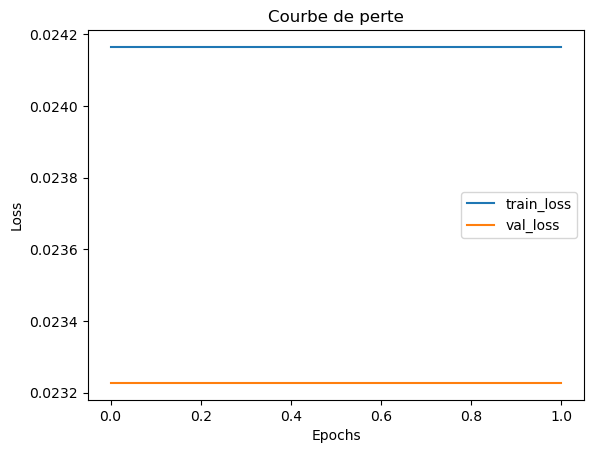

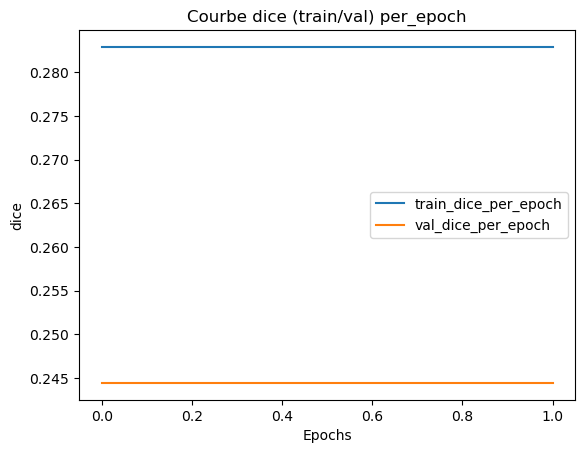

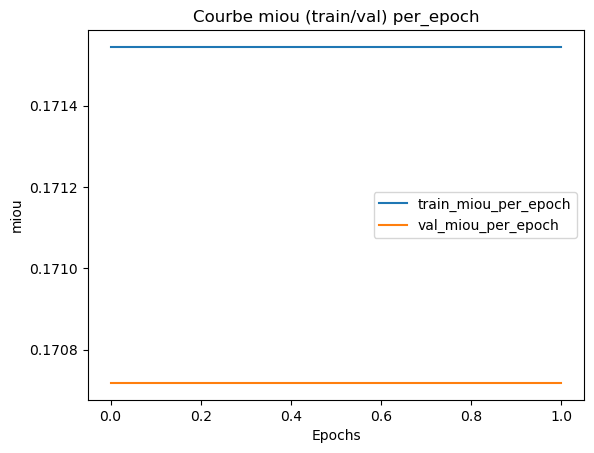

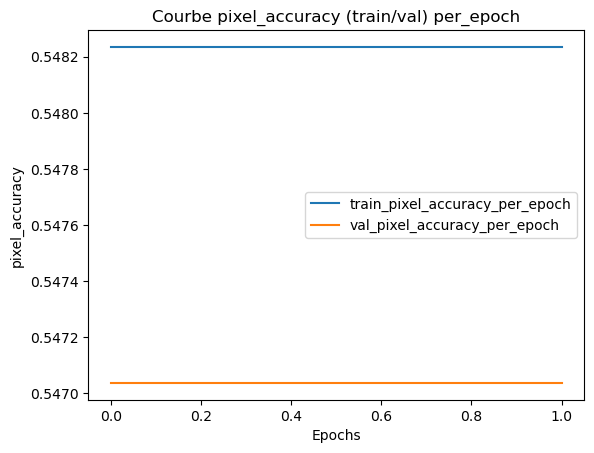

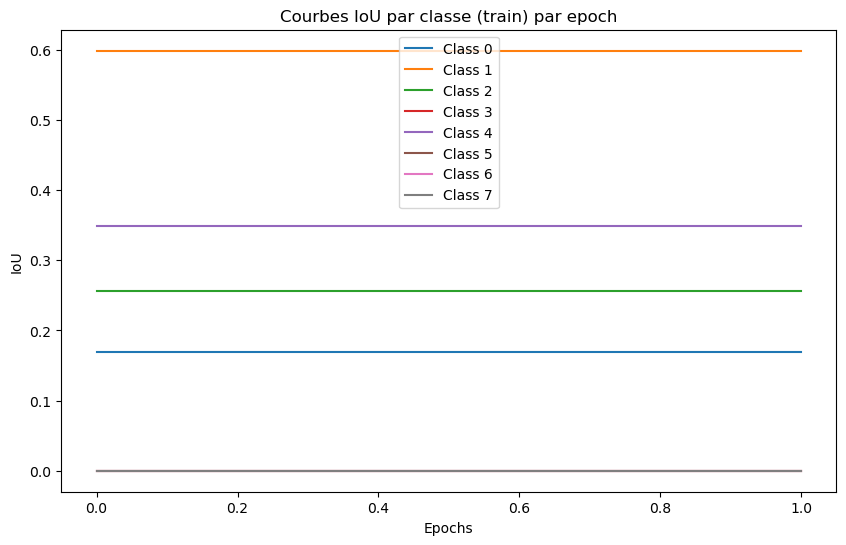

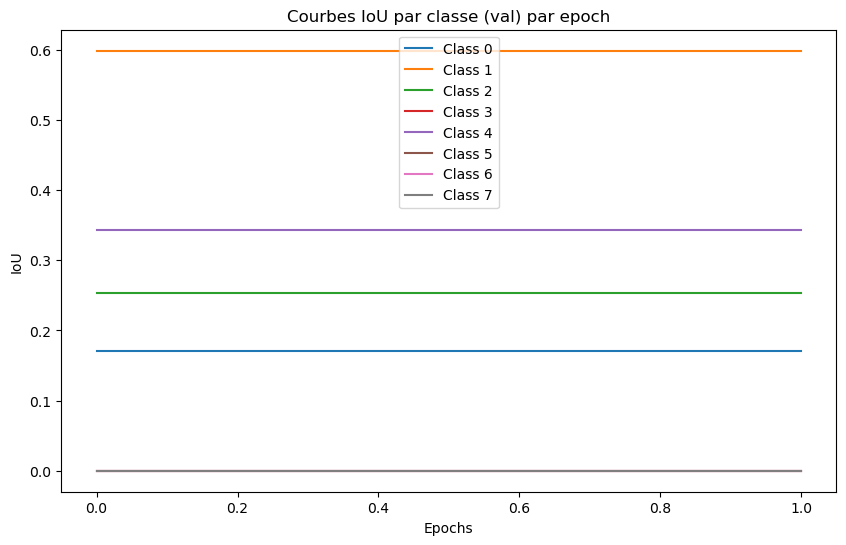

In [ ]:
metric_trainer_unet_mini = ModelMetricMLflow(run_id=run_id_trainer_unet_mini, monitor="val_dice", best_monitor="max")
metric_trainer_unet_mini.plot_loss_curves()
metric_trainer_unet_mini.plot_metric_curves()
metric_trainer_unet_mini.plot_per_class_iou_curves(split="train")
metric_trainer_unet_mini.plot_per_class_iou_curves(split="val")



In [ ]:
# load le dictionnaire d'évaluation finale
dict_evaluation_finale = trainer_unet_mini.evaluate_final_metrics(
    model=trainer_unet_mini.load_model(run_id=run_id_trainer_unet_mini),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset)
# Affiche les scores finaux pour chaque dataset et chaque métrique
metric_trainer_unet_mini.plot_final_metrics_comparison(dict_evaluation_finale, dataset_train=train_dataset)

/opt/anaconda3/envs/env_p8_chantepie/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 3s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 3s 

2025-08-08 23:05:31.627388: W tensorflow/core/framework/local_rendezvous.cc:404] Local rendezvous is aborting with status: INVALID_ARGUMENT: Shapes of all inputs must match: values[0].shape = [311951360] != values[1].shape = [2495610880]


InvalidArgumentError: {{function_node __wrapped__Pack_N_2_device_/job:localhost/replica:0/task:0/device:CPU:0}} Shapes of all inputs must match: values[0].shape = [311951360] != values[1].shape = [2495610880] [Op:Pack] name: stack

In [ ]:
# Pour charger le modèle du dernier run et faire des prédictions
model = trainer_unet_mini.load_model(run_id=run_id_trainer_unet_mini)


/opt/anaconda3/envs/env_p8_chantepie/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


/opt/anaconda3/envs/env_p8_chantepie/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 451ms/step


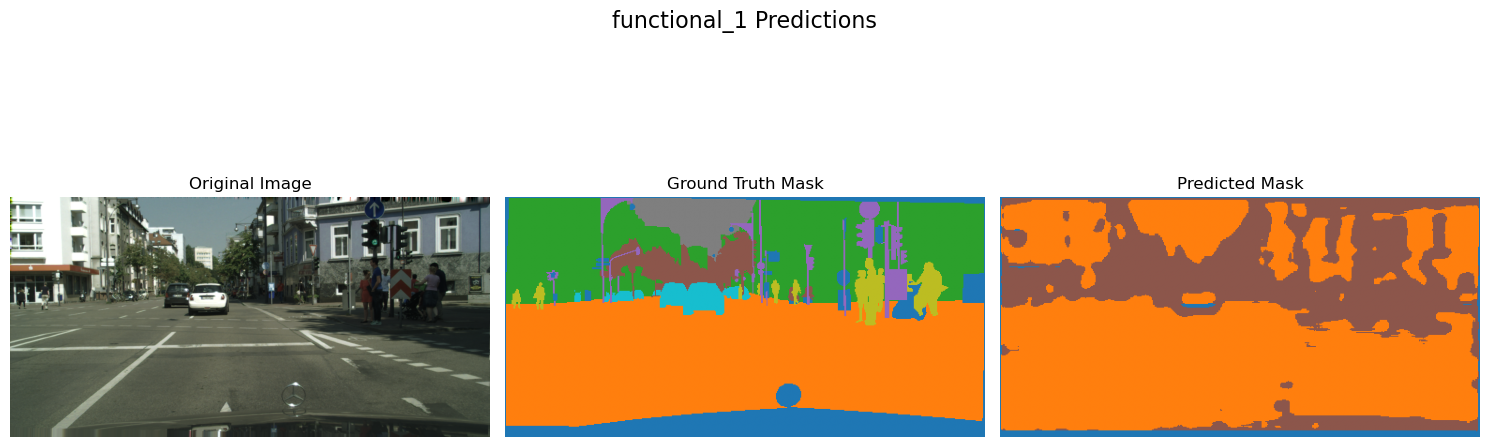

In [ ]:
index = 42
test_dataset.show_prediction(model, index)

## VGG16_Unet - Sans data-augmentation

### Récupération et préparation des datasets

In [ ]:

# path vers les nouveaux dossier train et test
train_dir = pathlib.Path("data/train")
test_dir = pathlib.Path("data/test")

# récupération des chemins pour les images et les masques du train
image_paths = sorted(list(train_dir.glob("*leftImg8bit.png")))
mask_paths = sorted(list(train_dir.glob("*labelIds.png")))

# association des chemins des images et des masques pour le train
full_train_paths = list(zip(image_paths, mask_paths))

# train_test_split pour créer l'ensemble de validation
train_paths, val_paths = train_test_split(full_train_paths, test_size=0.2, random_state=SEED)

# récupération des chemins pour les images et les masques du test
image_paths_test = sorted(list(test_dir.glob("*leftImg8bit.png")))
mask_paths_test = sorted(list(test_dir.glob("*labelIds.png")))
test_paths = list(zip(image_paths_test, mask_paths_test))



train_dataset = ImageSegmentationDataset(
    paths=train_paths,
    labels=labels,
    batch_size=BATCH_SIZE,
    augmentations=False,         # Pas d'augmentation pour le train
    normalize=True,
    shuffle=True,
    label_onehot=False,
    sample_weights=True,        # Poids de classes activés
    model_name="vgg16_unet" #pour normalisation adpatée au modèle
)

val_dataset = ImageSegmentationDataset(
    paths=val_paths,
    labels=labels,
    batch_size=BATCH_SIZE,
    augmentations=False,        # Pas d'augmentation pour la val
    normalize=True,
    shuffle=False,
    label_onehot=False,
    sample_weights=True,        # Poids de classes activés
    model_name="vgg16_unet" #pour normalisation adpatée au modèle
)

test_dataset = ImageSegmentationDataset(
    paths=test_paths,
    labels=labels,
    batch_size=BATCH_SIZE,
    augmentations=False,        # Pas d'augmentation pour le test
    normalize=True,
    shuffle=False,
    label_onehot=False,
    sample_weights=True,        # Poids de classes activés
    model_name="vgg16_unet") #pour normalisation adpatée au modèle


In [ ]:
len(full_train_paths)

2975

In [ ]:
len(test_paths)

500

In [ ]:
last_index_train = len(train_dataset) - 1
last_index_val = len(val_dataset) - 1
last_index_test = len(test_dataset) - 1
print(last_index_train)
print(last_index_val)
print(last_index_test)

297
74
62


In [ ]:
# Vérifie le dernier batch du train
images, masks, weights = train_dataset[last_index_train]
print("dernier batch train :", images.shape, masks.shape, weights.shape)

# Vérifie le dernier batch de la validation
images_val, masks_val, weights_val = val_dataset[last_index_val]
print("dernier batch val :", images_val.shape, masks_val.shape, weights_val.shape)

# Vérifie le dernier batch du test
images_test, masks_test, weights_test = test_dataset[last_index_test]
print("dernier batch test :", images_test.shape, masks_test.shape, weights_test.shape)

dernier batch train : (4, 256, 512, 3) (4, 256, 512) (4, 256, 512)
dernier batch val : (3, 256, 512, 3) (3, 256, 512) (3, 256, 512)
dernier batch test : (4, 256, 512, 3) (4, 256, 512) (4, 256, 512)


### Train VGG16_Unet

In [ ]:
trainer_vgg16_unet = SegmentationExperiment(
    model_fn=lambda input_shape, num_classes, loss: build_vgg16_unet(
        input_shape=input_shape,
        num_classes=num_classes,
        loss=loss,
        freeze_encoder=True
    ),
    model_name="VGG16_UNet",
)

In [ ]:
print("BATCH_SIZE:", BATCH_SIZE)
print("SEED:", SEED)
print("PATIENCE:", PATIENCE)
#print("OPTIMIZER:", OPTIMIZER)

BATCH_SIZE: 8
SEED: 42
PATIENCE: 7


In [ ]:
run_id_trainer_VGG16_Unet = trainer_vgg16_unet.train_and_log(train_dataset, val_dataset, test_dataset, epochs=1, batch_size=BATCH_SIZE )

Model: "functional_2"

┏━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━┓
┃ Layer (type)        ┃ Output Shape      ┃    Param # ┃ Connected to      ┃
┡━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━┩
│ input_layer_2       │ (None, 256, 512,  │          0 │ -                 │
│ (InputLayer)        │ 3)                │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv1        │ (None, 256, 512,  │      1,792 │ input_layer_2[0]… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_conv2        │ (None, 256, 512,  │     36,928 │ block1_conv1[0][… │
│ (Conv2D)            │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block1_pool         │ (None, 128, 256,  │          0 │ block1_conv2[0][… │
│ (MaxPooling2D)      │ 64)               │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv1        │ (None, 128, 256,  │     73,856 │ block1_pool[0][0] │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_conv2        │ (None, 128, 256,  │    147,584 │ block2_conv1[0][… │
│ (Conv2D)            │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block2_pool         │ (None, 64, 128,   │          0 │ block2_conv2[0][… │
│ (MaxPooling2D)      │ 128)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv1        │ (None, 64, 128,   │    295,168 │ block2_pool[0][0] │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv2        │ (None, 64, 128,   │    590,080 │ block3_conv1[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_conv3        │ (None, 64, 128,   │    590,080 │ block3_conv2[0][… │
│ (Conv2D)            │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block3_pool         │ (None, 32, 64,    │          0 │ block3_conv3[0][… │
│ (MaxPooling2D)      │ 256)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv1        │ (None, 32, 64,    │  1,180,160 │ block3_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv2        │ (None, 32, 64,    │  2,359,808 │ block4_conv1[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_conv3        │ (None, 32, 64,    │  2,359,808 │ block4_conv2[0][… │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block4_pool         │ (None, 16, 32,    │          0 │ block4_conv3[0][… │
│ (MaxPooling2D)      │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv1        │ (None, 16, 32,    │  2,359,808 │ block4_pool[0][0] │
│ (Conv2D)            │ 512)              │            │                   │
├─────────────────────┼───────────────────┼────────────┼───────────────────┤
│ block5_conv2        │ (None, 16, 32,    │  2,359,808 │ block5_conv1[0][

 Total params: 20,208,680 (77.09 MB)

 Trainable params: 5,493,992 (20.96 MB)

 Non-trainable params: 14,714,688 (56.13 MB)

1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 13s 13s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 14s 14s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 12s 12s/step
1/1 ━━━━━━━━

INFO:tensorflow:Assets written to: modelVGG16_UNet_tf/assets


INFO:tensorflow:Assets written to: modelVGG16_UNet_tf/assets


Saved artifact at 'modelVGG16_UNet_tf'. The following endpoints are available:

* Endpoint 'serve'
  args_0 (POSITIONAL_ONLY): TensorSpec(shape=(None, 256, 512, 3), dtype=tf.float32, name='keras_tensor_42')
Output Type:
  TensorSpec(shape=(None, 256, 512, 8), dtype=tf.float32, name=None)
Captures:
  6143733856: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143734736: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143937168: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143938400: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6131354080: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143938048: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143944560: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143944032: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143949312: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143949488: TensorSpec(shape=(), dtype=tf.resource, name=None)
  6143940864: TensorSpec(shape=(), dtype=tf.resourc

/opt/anaconda3/envs/env_p8_chantepie/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 2s 2s/step


2025/08/07 05:08:43 WARNING mlflow.utils.environment: Encountered an unexpected error while inferring pip requirements (model URI: /var/folders/nf/_fsdpljs7vg7_n1ql08pmsyr0000gn/T/tmp3by4bzxp/model, flavor: keras). Fall back to return ['keras==3.10.0']. Set logging level to DEBUG to see the full traceback. 
Successfully registered model 'VGG16_UNet'.
Created version '1' of model 'VGG16_UNet'.


### Évaluation

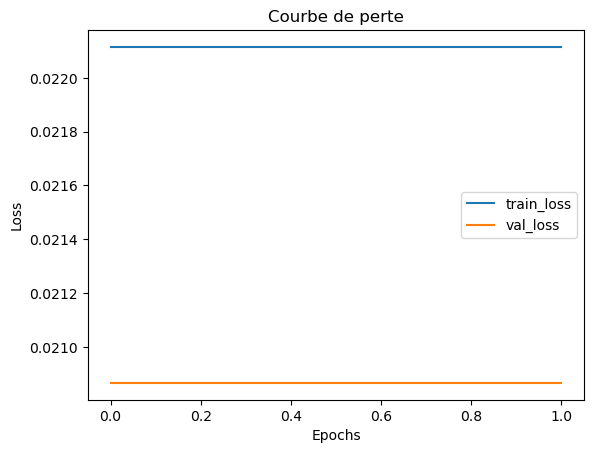

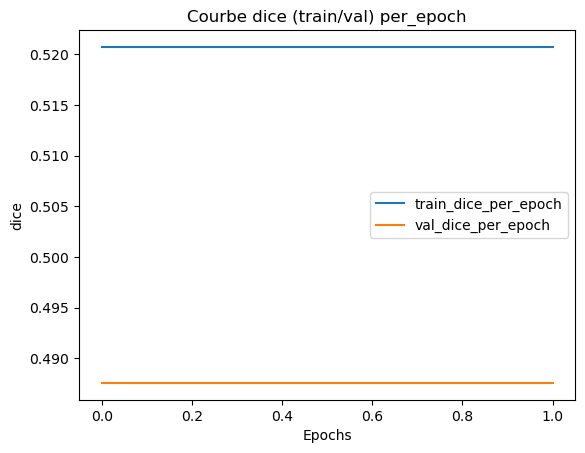

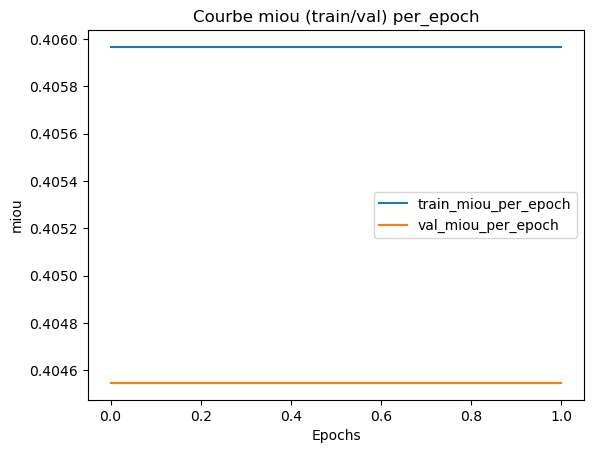

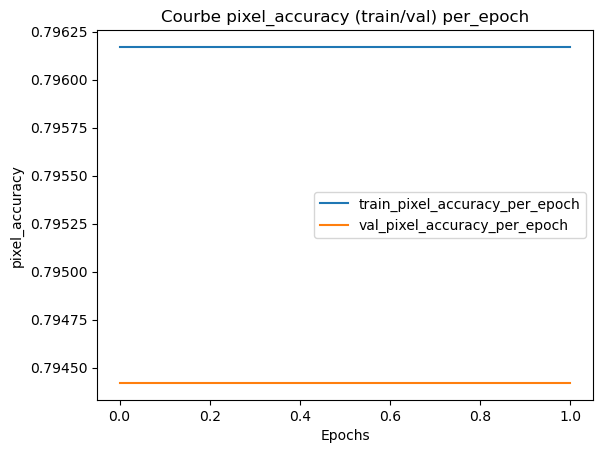

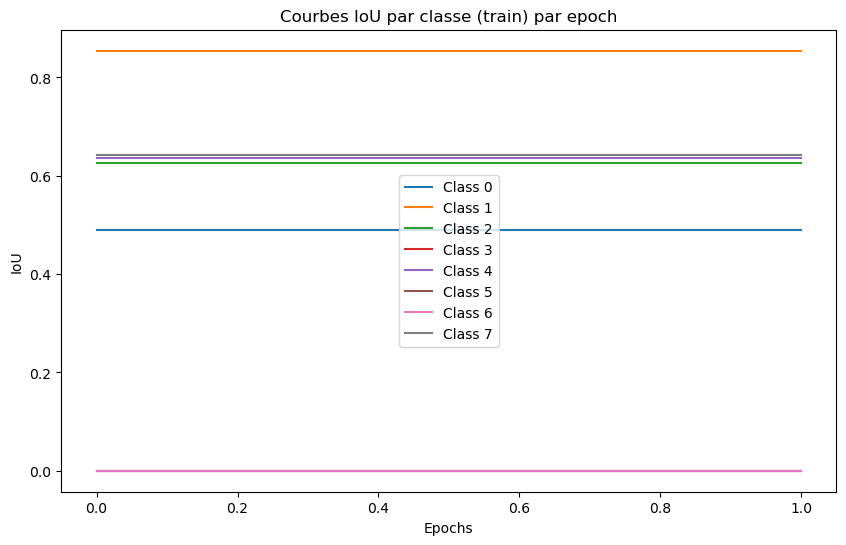

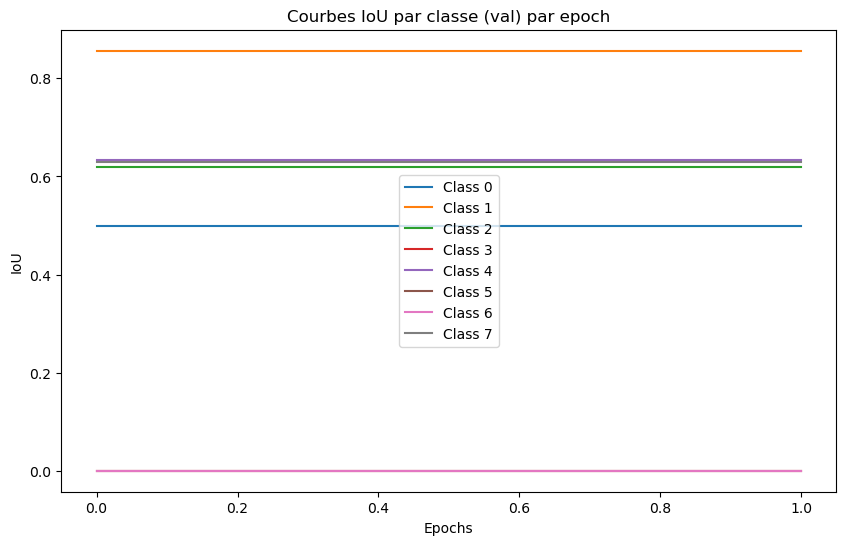

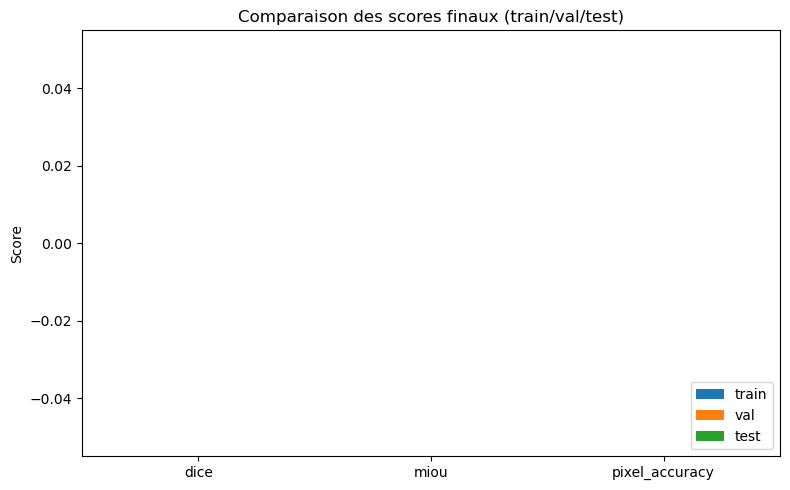

In [ ]:
metric_trainer_vgg16_unet = ModelMetricMLflow(run_id=run_id_trainer_VGG16_Unet, monitor="val_dice", best_monitor="max")
metric_trainer_vgg16_unet.plot_loss_curves()
metric_trainer_vgg16_unet.plot_metric_curves()
metric_trainer_vgg16_unet.plot_per_class_iou_curves(split="train")
metric_trainer_vgg16_unet.plot_per_class_iou_curves(split="val")


In [ ]:
# load le dictionnaire d'évaluation finale
dict_evaluation_finale = trainer_vgg16_unet.evaluate_final_metrics(
    model=trainer_vgg16_unet.load_model(run_id=run_id_trainer_VGG16_Unet),
    train_dataset=train_dataset,
    val_dataset=val_dataset,
    test_dataset=test_dataset)
# Affiche les scores finaux pour chaque dataset et chaque métrique
metric_trainer_vgg16_unet.plot_final_metrics_comparison(dict_evaluation_finale, dataset_train=train_dataset)

In [ ]:
# Pour charger le modèle du dernier run et faire des prédictions
model = trainer_vgg16_unet.load_model(run_id=run_id_trainer_VGG16_Unet)


/opt/anaconda3/envs/env_p8_chantepie/lib/python3.10/site-packages/keras/src/saving/saving_lib.py:802: UserWarning: Skipping variable loading for optimizer 'rmsprop', because it has 14 variables whereas the saved optimizer has 26 variables. 
  saveable.load_own_variables(weights_store.get(inner_path))


/opt/anaconda3/envs/env_p8_chantepie/lib/python3.10/site-packages/tensorflow/python/data/ops/structured_function.py:258: UserWarning: Even though the `tf.config.experimental_run_functions_eagerly` option is set, this option does not apply to tf.data functions. To force eager execution of tf.data functions, please use `tf.data.experimental.enable_debug_mode()`.
  warnings.warn(


1/1 ━━━━━━━━━━━━━━━━━━━━ 1s 1s/step


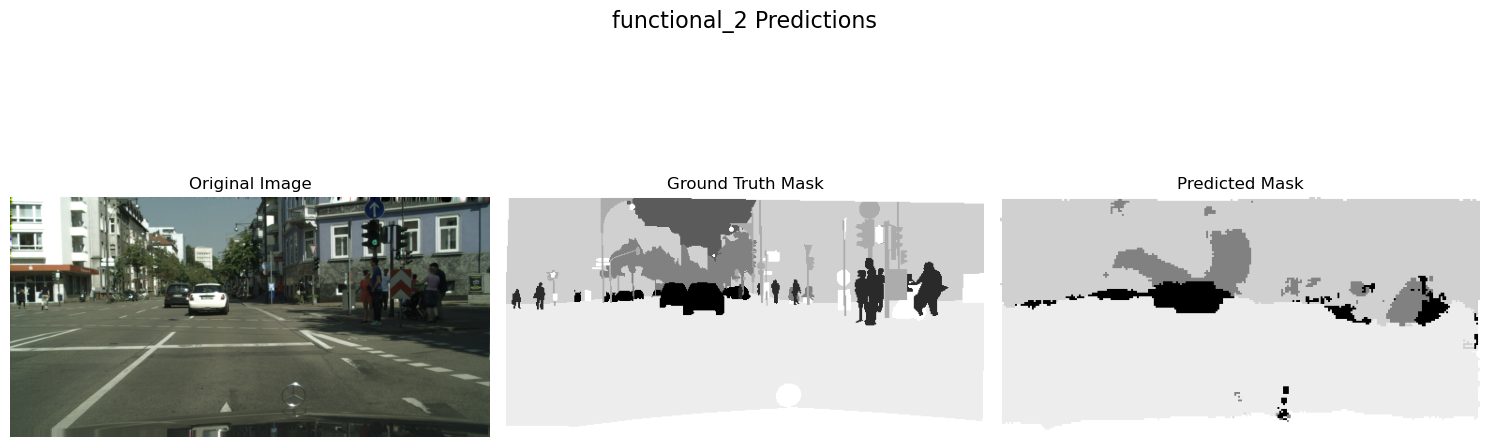

In [ ]:
index = 42
test_dataset.show_prediction(model, index)
